# UTKFace VGG16

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b3

from sklearn.metrics import classification_report, accuracy_score

# created library
import dataaugmentation
import mydata
from skindetection import SkinExtraction
from skincolors import IndividualTypologyAngle

from mymodels import TransDataset, VGG16Model
import training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
db = "UTKFace"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

# Data Trainning

In [8]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (200, 200)


Validation Accuracy: 0.6646 | Loss: 0.6459 | F1: 0.6975
Validation Accuracy: 0.7034 | Loss: 0.5719 | F1: 0.6871
Validation Accuracy: 0.7484 | Loss: 0.5475 | F1: 0.7501
Validation Accuracy: 0.8119 | Loss: 0.4158 | F1: 0.8108
Validation Accuracy: 0.7696 | Loss: 0.6064 | F1: 0.7985
Validation Accuracy: 0.8190 | Loss: 0.3935 | F1: 0.7953
Validation Accuracy: 0.8431 | Loss: 0.3964 | F1: 0.8315
Validation Accuracy: 0.8307 | Loss: 0.3750 | F1: 0.8219
Validation Accuracy: 0.8503 | Loss: 0.3502 | F1: 0.8464
Validation Accuracy: 0.7738 | Loss: 0.4562 | F1: 0.7383
Validation Accuracy: 0.8323 | Loss: 0.3633 | F1: 0.8097
Validation Accuracy: 0.8360 | Loss: 0.4703 | F1: 0.8172
Validation Accuracy: 0.8497 | Loss: 0.4248 | F1: 0.8580
Validation Accuracy: 0.8685 | Loss: 0.3032 | F1: 0.8585
Validation Accuracy: 0.8667 | Loss: 0.3182 | F1: 0.8583
Validation Accuracy: 0.8540 | Loss: 0.3963 | F1: 0.8378
Validation Accuracy: 0.8130 | Loss: 0.4093 | F1: 0.8355
Validation Accuracy: 0.8574 | Loss: 0.3634 | F1:

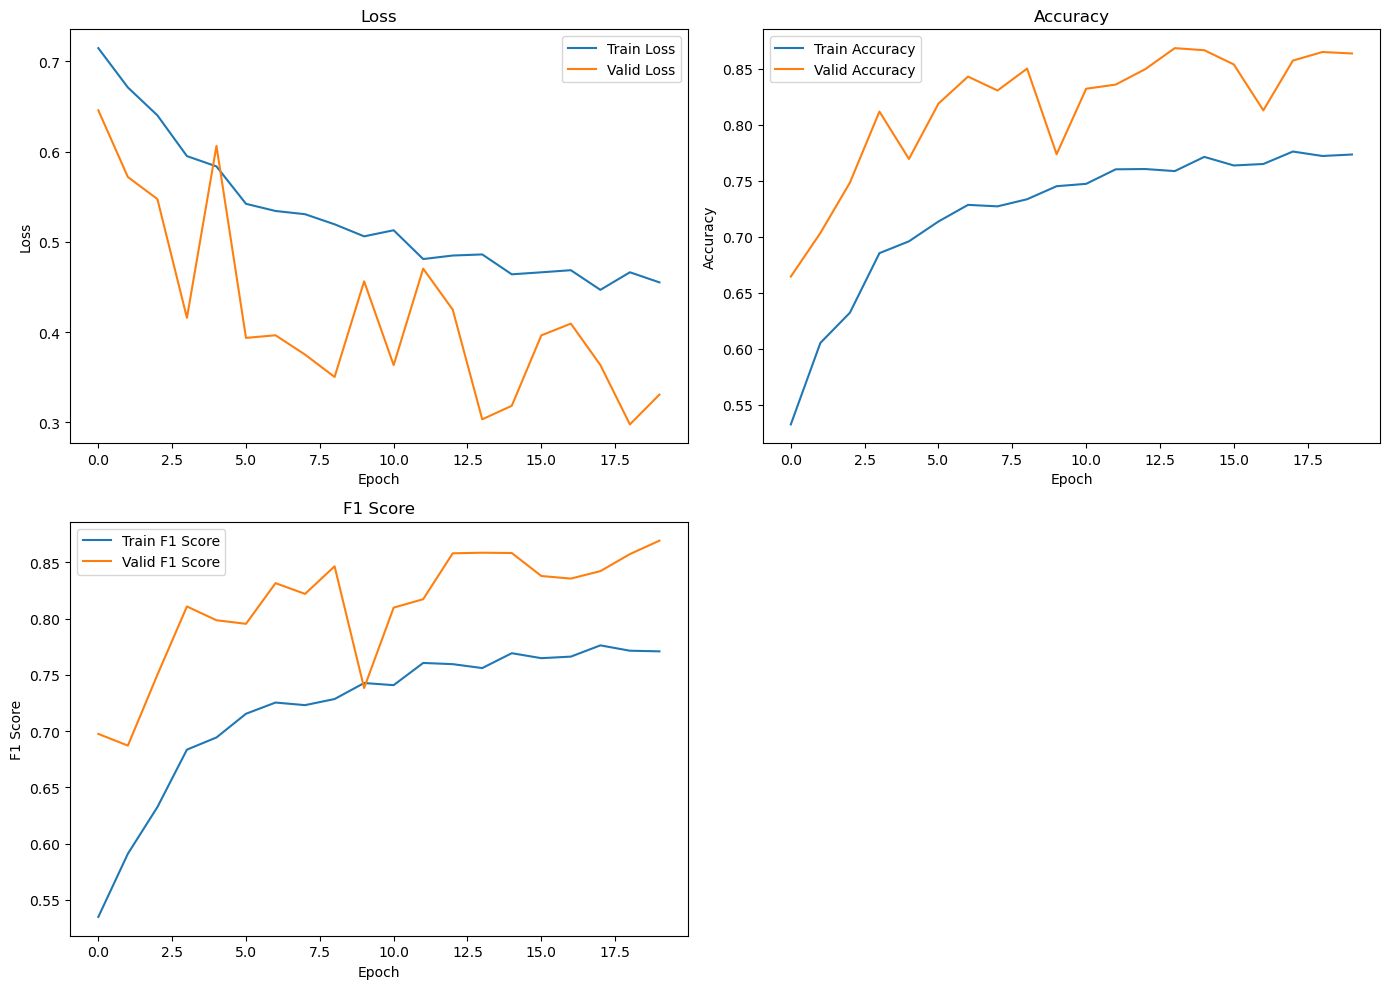

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/vgg/"
model = VGG16Model().to(device)

# Train the model
num_epochs = 20
lr = 0.0001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

##  Evaluation

In [10]:
model = VGG16Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0.5 else 0 for x in outputs) # Appendは１つ、extendは複数
        
df_test["predictions"] = test_predictions

In [11]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_vgg.csv", index=False)

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      2378
           1       0.94      0.78      0.85      2409

    accuracy                           0.86      4787
   macro avg       0.87      0.86      0.86      4787
weighted avg       0.88      0.86      0.86      4787

Skin tone 3: Accuracy 0.8921901528013583
Skin tone 0: Accuracy 0.85
Skin tone 1: Accuracy 0.880481513327601
Skin tone 2: Accuracy 0.833605220228385
